In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "drive/My Drive/"

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
#!pip install catboost

     |████████████████████████████████| 66.3MB 53kB/s 


## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import lightgbm as lgb

## Importing Data

In [2]:
# Import the train data
train = pd.read_csv('datasets/SUPCOM_Train.csv')

# Import the test data
test = pd.read_csv('datasets/SUPCOM_Test.csv')

Submission = pd.read_csv('datasets/SUPCOM_SampleSubmission.csv')

In [3]:
target = train.target.values
print(target.shape)

(21295,)


In [4]:
print(train.shape, test.shape)

(21295, 121) (7517, 120)


In [5]:
# Combine train and test data for easy preprocessing
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop = True)
print(data.shape)
data.head()

(28812, 121)


,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,target,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,id
0,44,6210,C,99,0,3707,4,2,2,2,...,16.639203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id17437
1,401,14383,M,22,0,6105,4,2,2,2,...,17.827703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id5086
2,243,11555,M,23,0,5751,4,2,2,2,...,15.473503,25387000.0,0.0,0.0,4571280.0,NaN,NaN,NaN,NaN,train_id1443
3,72,6175,C,99,0,4402,4,2,2,2,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id15469
4,42,1417,M,23,0,6302,4,2,2,2,...,14.286244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id14368


## Data quality check 

In [6]:
# This function seperate the columns into the various data types
def data_types(dataframe):
  int_col = []
  continuous_col = []
  cat_col = []
  for column in train.columns:
    if train[column].dtypes == 'int64':
      int_col.append(column)
    elif train[column].dtypes == 'float':
      continuous_col.append(column)
    else:
      cat_col.append(column)
  return int_col, continuous_col, cat_col

In [7]:
int_col, continuous_col, cat_col = data_types(data)

print('Ordinal Variables', len(int_col))
print('Continuous Variables',len(continuous_col))
print('Categorical Variables', len(cat_col))


Ordinal Variables 16
Continuous Variables 103
Categorical Variables 2


### Understanding the int64 data type variables

---



In [8]:
data[int_col].describe()

,BCT_CODBUR,CTR_MATFIS,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,CTR_OBLDCO,CTR_OBLTVA,CTR_OBLTCL,CTR_RATISS,EXE_EXERCI,RES_ANNIMP
count,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000
mean,215.855546,7816.644315,59.239969,0.049181,4825.815945,4.453700,1.960121,1.976572,1.927669,1.948702,1.005206,2.039289,2.983236,0.022144,2014.516243,2014.516243
std,163.139993,4489.238442,38.531542,0.230543,1165.478787,1.204495,0.195679,0.155336,0.263688,0.223267,0.071967,0.194285,0.182054,0.209280,1.336841,1.336841
min,9.000000,1.000000,10.000000,0.000000,1002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2013.000000,2013.000000
25%,92.000000,3949.000000,22.000000,0.000000,4203.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,2013.000000,2013.000000
50%,192.000000,7851.500000,23.000000,0.000000,4417.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,2014.000000,2014.000000
75%,254.000000,11710.250000,99.000000,0.000000,6102.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,2015.000000,2015.000000
max,700.000000,15603.000000,99.000000,2.000000,8999.000000,9.000000,2.000000,5.000000,5.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2018.000000,2018.000000


Integer Variables to drop
These are redundant columns made up of years and codes. Will will drop them later in the study.
['BCT_CODBUR', 'CTR_MATFIS', 'FJU_CODFJU', 'CTR_CESSAT', 'ACT_CODACT', 'EXE_EXERCI', 'RES_ANNIMP']


In [9]:
int_col_use = ['CTR_OBLDIR', 'CTR_OBLACP', 'CTR_OBLRES', 'CTR_OBLFOP', 'CTR_OBLTFP', 'CTR_OBLDCO', 'CTR_OBLTVA', 'CTR_OBLTCL', 'CTR_RATISS']
int_col_drop = ['BCT_CODBUR', 'CTR_MATFIS', 'FJU_CODFJU', 'CTR_CESSAT', 'ACT_CODACT', 'EXE_EXERCI', 'RES_ANNIMP']

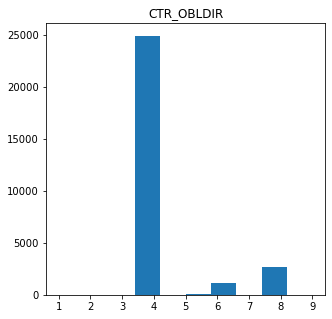

******************************************************************************************************************************************************


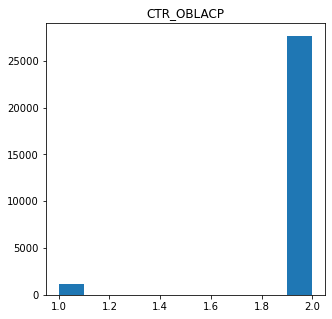

******************************************************************************************************************************************************


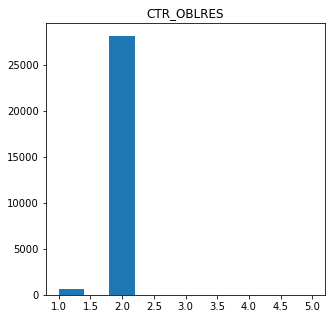

******************************************************************************************************************************************************


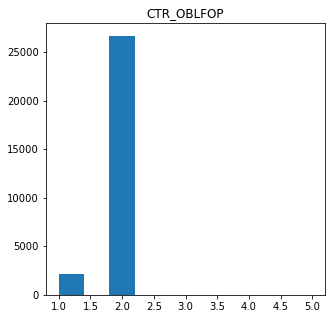

******************************************************************************************************************************************************


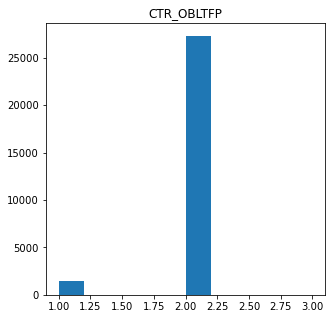

******************************************************************************************************************************************************


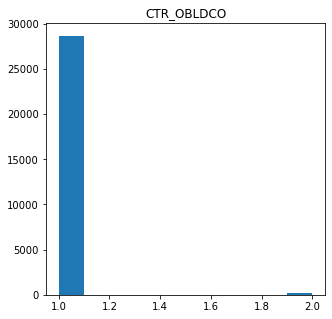

******************************************************************************************************************************************************


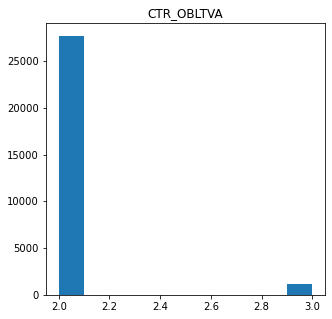

******************************************************************************************************************************************************


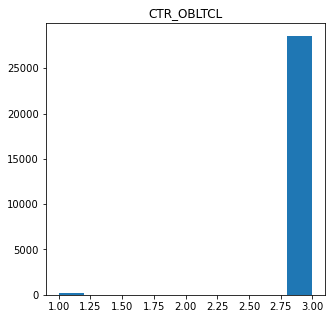

******************************************************************************************************************************************************


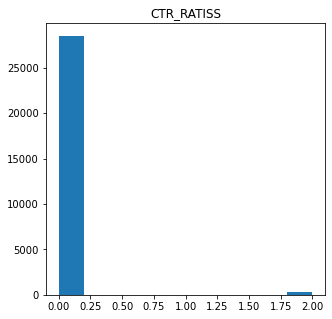

******************************************************************************************************************************************************


In [10]:
# The distribution of variables
for column in int_col_use:
  plt.figure(figsize = (5,5))
  plt.hist(data[column])
  plt.title(column)
  plt.show()
  print( '***' * 50)

### Understanding the float data type variables

In [11]:
data[continuous_col].describe()

,CTR_OFODEC,CTR_OFODEP,CTR_OFODET,CTR_OBLAUT,CTR_OBLASS,CTR_ODTIMB,CTR_OBLTHO,CTR_OBLDLI,CTR_OBLTVI,TVA_CHAFF6,...,AX5_MNTMAR,target,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C
count,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,2.656700e+04,...,2.184300e+04,21295.000000,2.479000e+03,2.479000e+03,2.479000e+03,2.479000e+03,2.865000e+03,2.865000e+03,2.865000e+03,2.865000e+03
mean,1.091872,1.003368,1.017222,1.019756,1.000069,1.475122,1.012743,1.037568,1.002118,1.773663e+08,...,1.030642e+09,11.780084,8.243376e+09,5.433622e+06,6.729353e+05,4.461729e+08,8.660866e+08,1.359557e+06,2.469147e+04,1.414242e+08
std,0.288850,0.057937,0.130099,0.139164,0.008333,0.499389,0.112164,0.190153,0.045974,2.172927e+09,...,8.053263e+09,7.085772,1.175995e+11,1.793214e+08,1.933025e+07,4.105284e+09,4.265450e+09,1.535796e+07,6.111973e+05,7.400228e+08
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,...,0.000000e+00,0.000000,9.290000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.910000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,...,0.000000e+00,0.000000,2.993120e+07,0.000000e+00,0.000000e+00,4.323436e+06,1.957640e+07,0.000000e+00,0.000000e+00,3.021017e+06
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,...,4.857380e+06,14.981121,1.891549e+08,0.000000e+00,0.000000e+00,2.806525e+07,5.722739e+07,0.000000e+00,0.000000e+00,8.882093e+06
75%,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000e+00,...,1.600982e+08,16.625623,9.674418e+08,0.000000e+00,0.000000e+00,1.459402e+08,2.754562e+08,0.000000e+00,0.000000e+00,4.449364e+07
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.060280e+11,...,6.939760e+11,23.591334,3.414510e+12,8.897885e+09,8.212377e+08,1.608780e+11,8.394391e+10,4.044067e+08,2.614500e+07,1.510990e+10


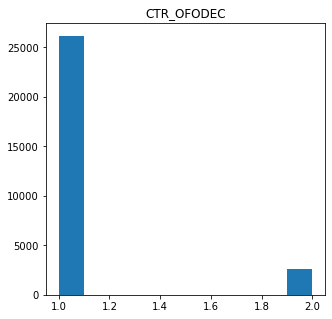

******************************************************************************************************************************************************


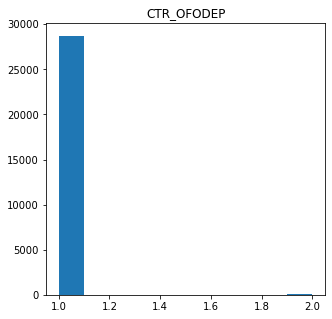

******************************************************************************************************************************************************


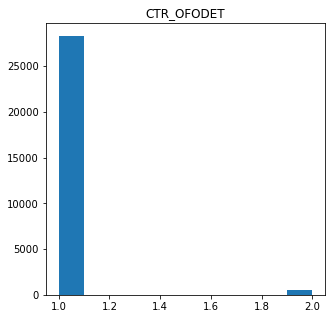

******************************************************************************************************************************************************


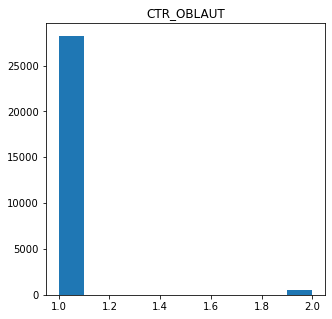

******************************************************************************************************************************************************


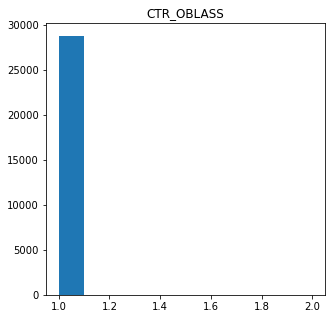

******************************************************************************************************************************************************


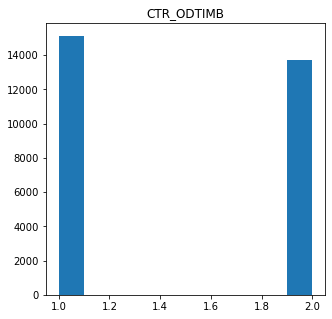

******************************************************************************************************************************************************


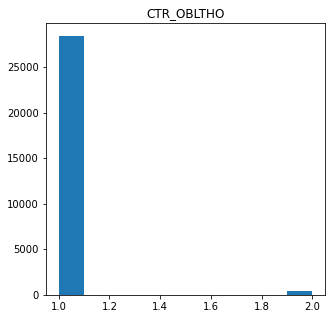

******************************************************************************************************************************************************


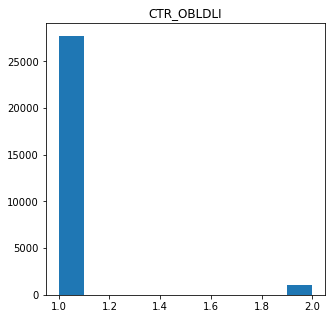

******************************************************************************************************************************************************


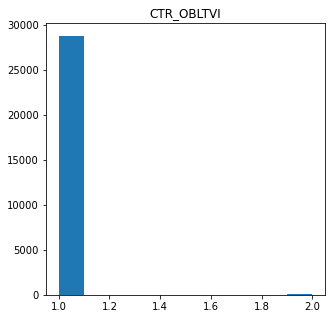

******************************************************************************************************************************************************


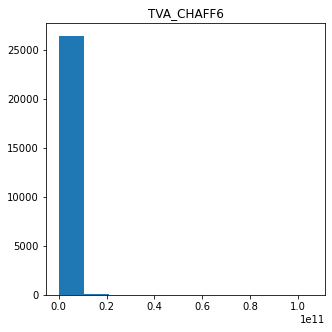

******************************************************************************************************************************************************


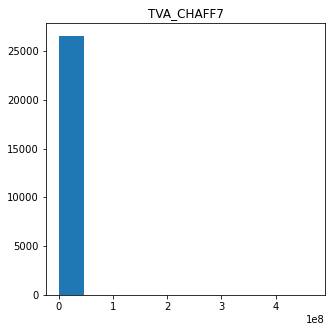

******************************************************************************************************************************************************


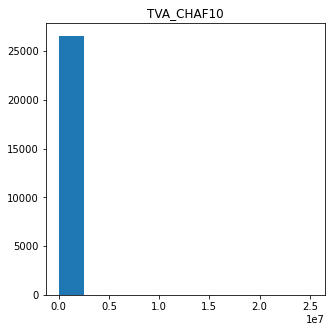

******************************************************************************************************************************************************


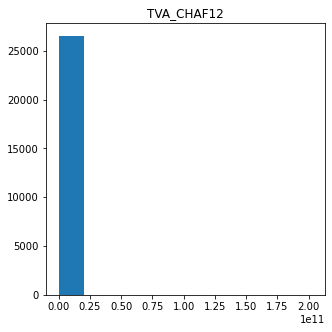

******************************************************************************************************************************************************


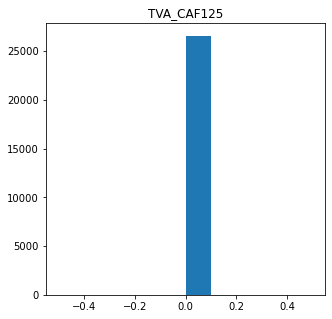

******************************************************************************************************************************************************


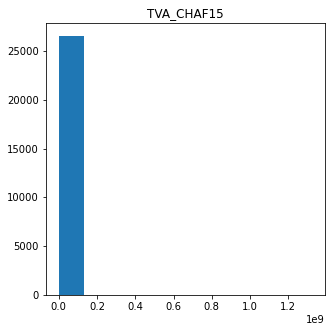

******************************************************************************************************************************************************


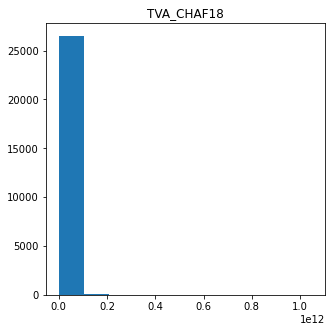

******************************************************************************************************************************************************


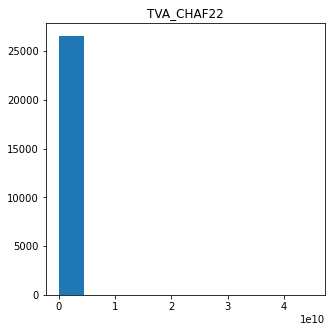

******************************************************************************************************************************************************


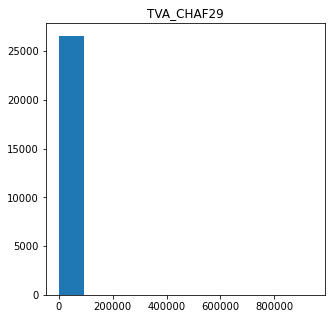

******************************************************************************************************************************************************


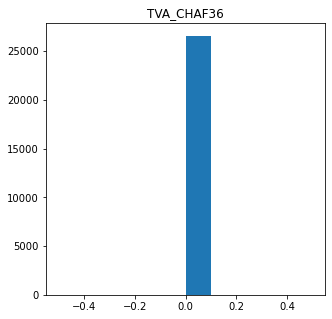

******************************************************************************************************************************************************


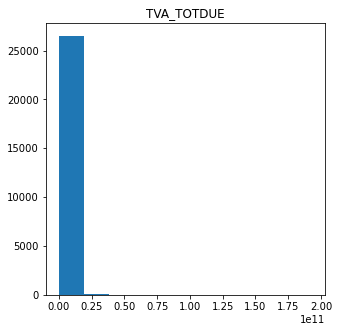

******************************************************************************************************************************************************


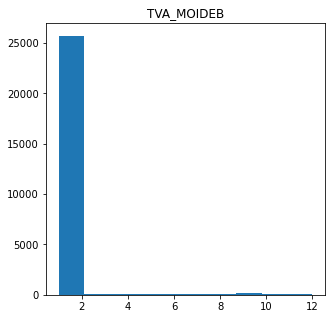

******************************************************************************************************************************************************


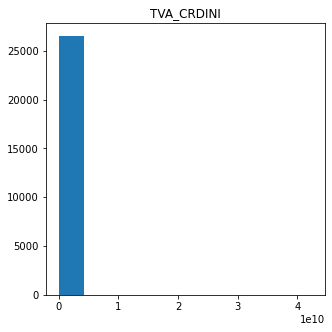

******************************************************************************************************************************************************


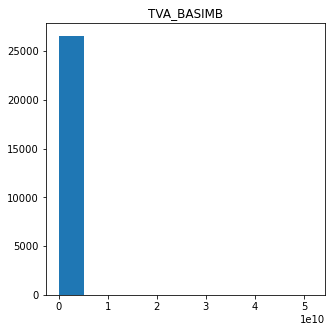

******************************************************************************************************************************************************


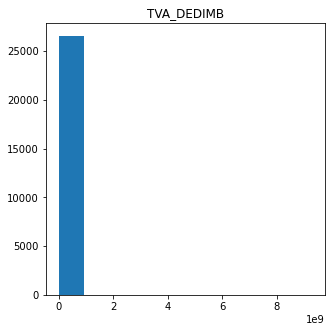

******************************************************************************************************************************************************


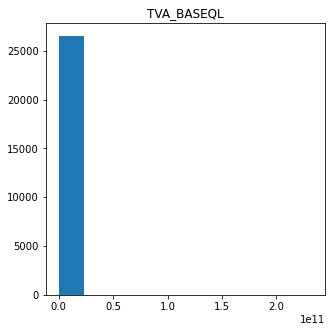

******************************************************************************************************************************************************


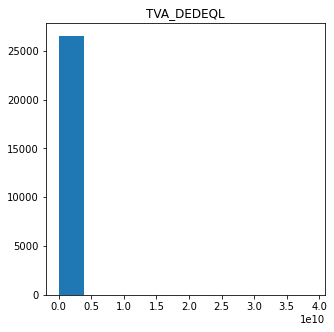

******************************************************************************************************************************************************


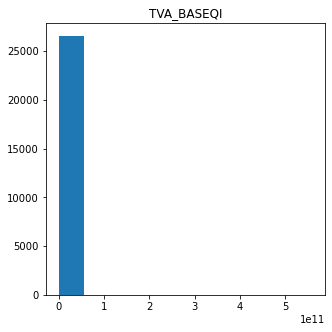

******************************************************************************************************************************************************


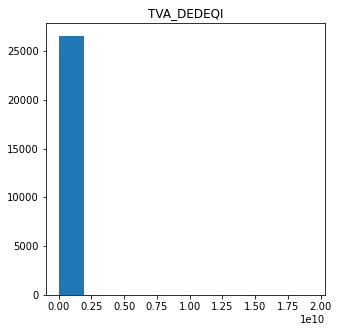

******************************************************************************************************************************************************


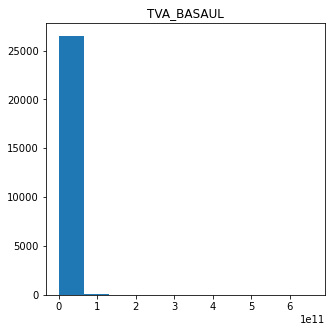

******************************************************************************************************************************************************


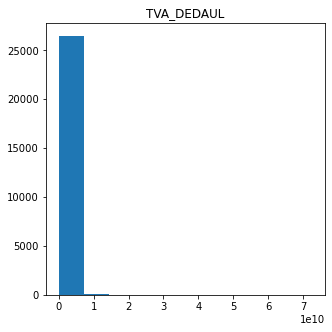

******************************************************************************************************************************************************


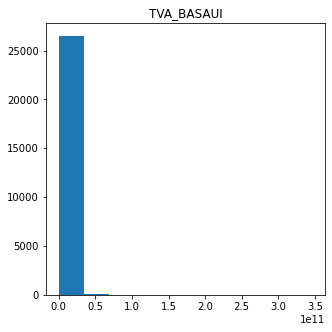

******************************************************************************************************************************************************


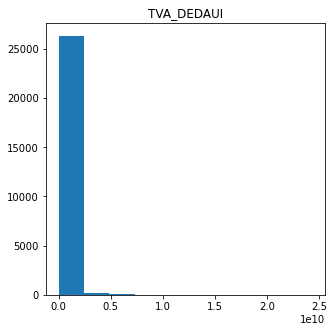

******************************************************************************************************************************************************


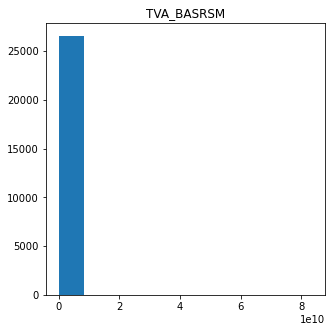

******************************************************************************************************************************************************


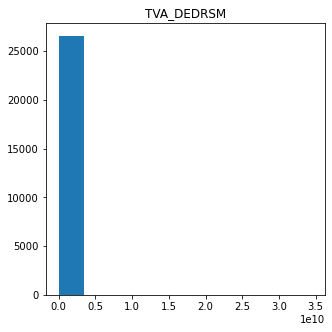

******************************************************************************************************************************************************


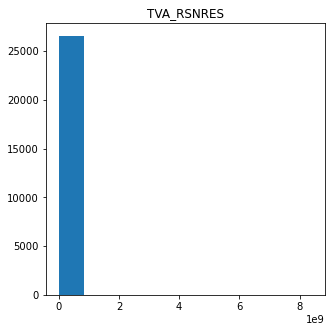

******************************************************************************************************************************************************


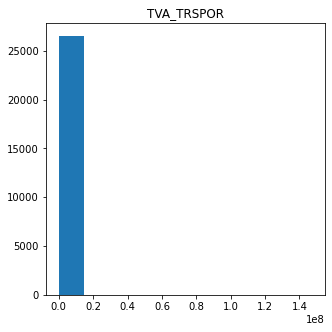

******************************************************************************************************************************************************


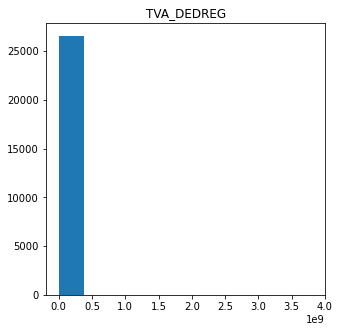

******************************************************************************************************************************************************


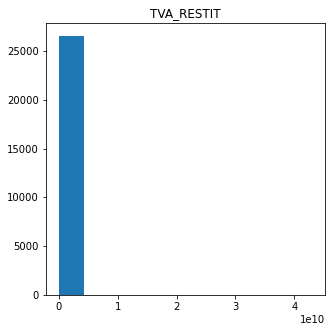

******************************************************************************************************************************************************


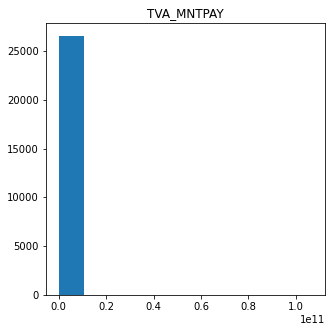

******************************************************************************************************************************************************


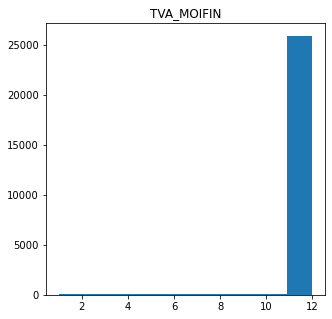

******************************************************************************************************************************************************


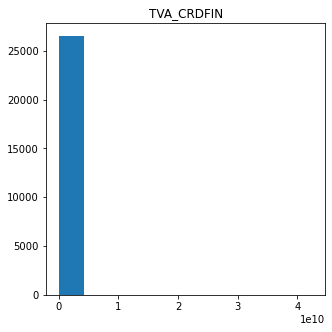

******************************************************************************************************************************************************


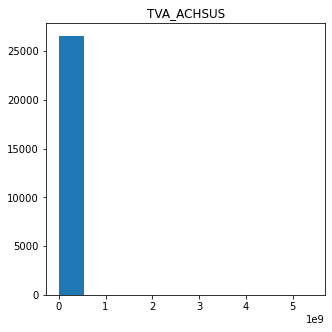

******************************************************************************************************************************************************


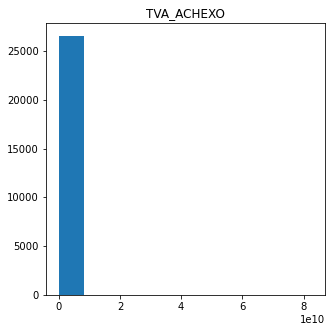

******************************************************************************************************************************************************


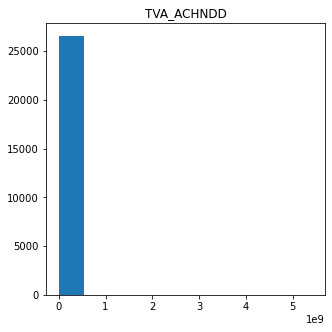

******************************************************************************************************************************************************


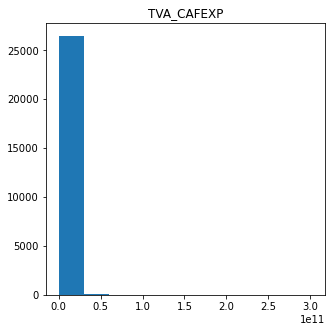

******************************************************************************************************************************************************


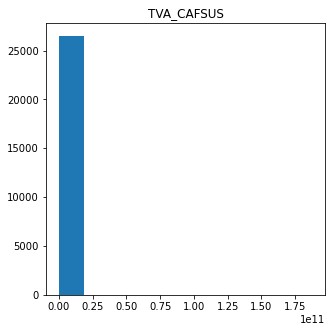

******************************************************************************************************************************************************


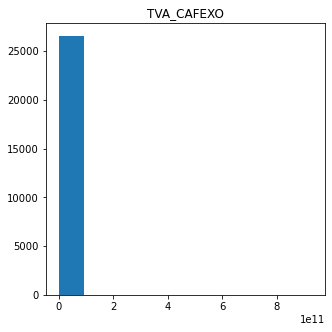

******************************************************************************************************************************************************


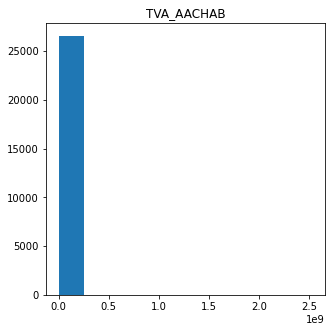

******************************************************************************************************************************************************


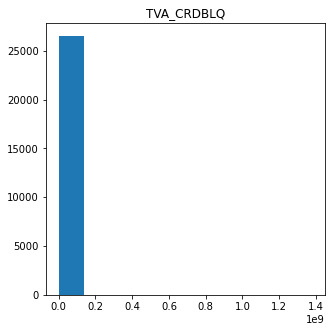

******************************************************************************************************************************************************


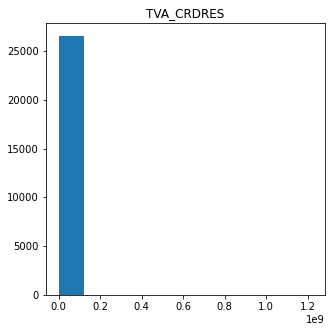

******************************************************************************************************************************************************


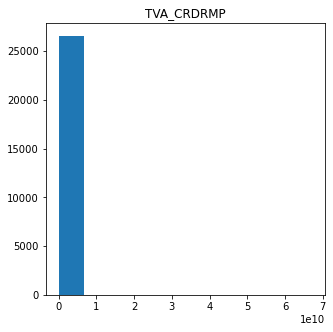

******************************************************************************************************************************************************


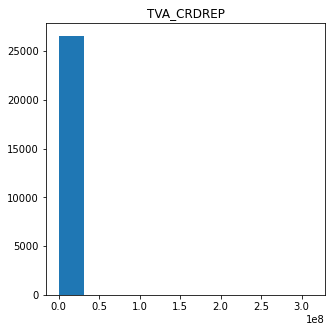

******************************************************************************************************************************************************


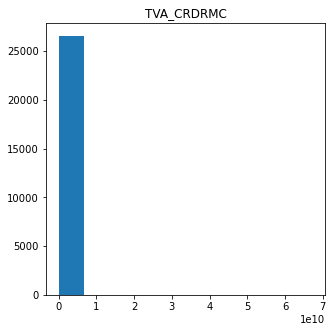

******************************************************************************************************************************************************


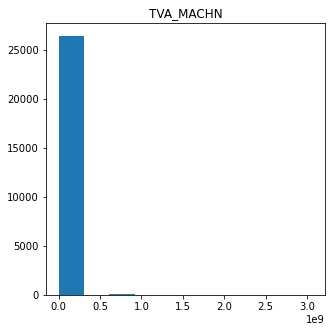

******************************************************************************************************************************************************


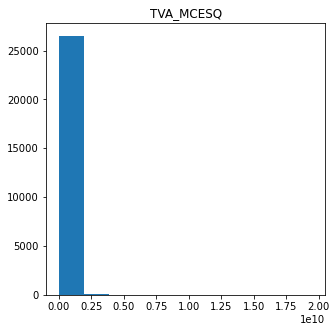

******************************************************************************************************************************************************


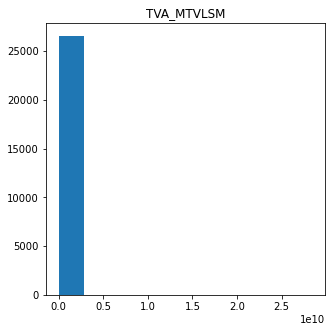

******************************************************************************************************************************************************


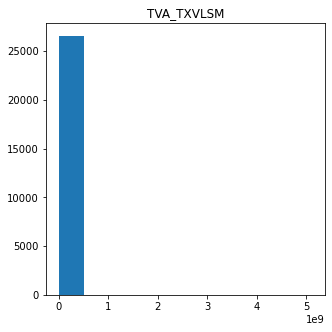

******************************************************************************************************************************************************


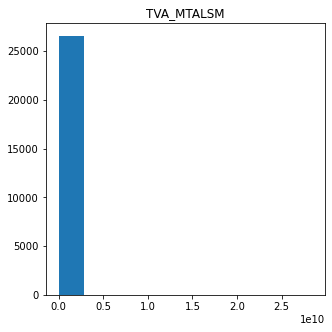

******************************************************************************************************************************************************


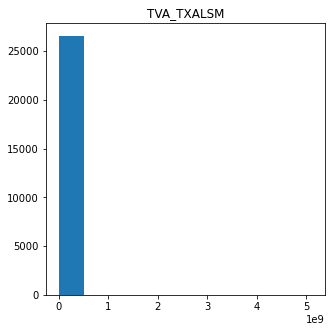

******************************************************************************************************************************************************


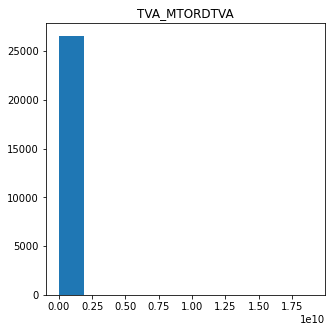

******************************************************************************************************************************************************


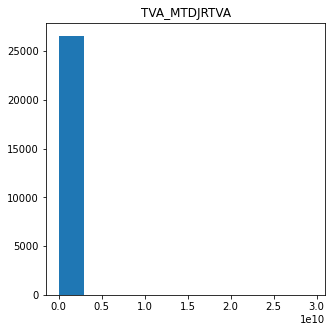

******************************************************************************************************************************************************


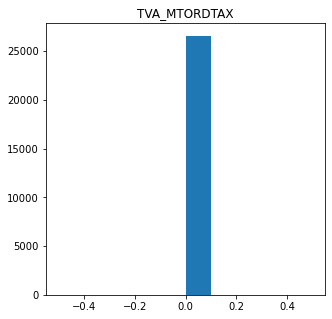

******************************************************************************************************************************************************


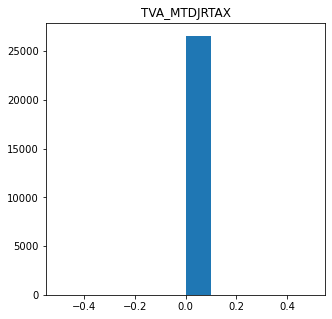

******************************************************************************************************************************************************


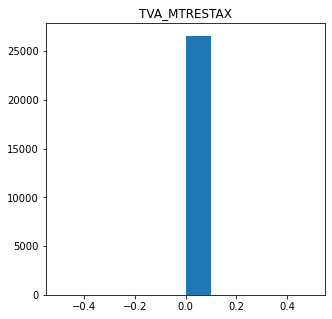

******************************************************************************************************************************************************


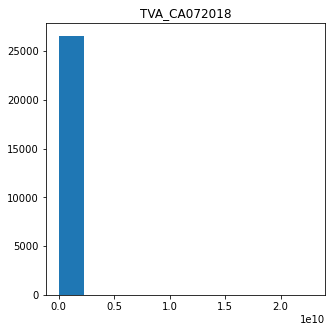

******************************************************************************************************************************************************


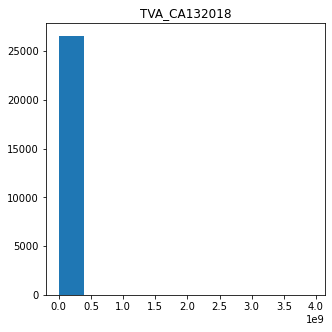

******************************************************************************************************************************************************


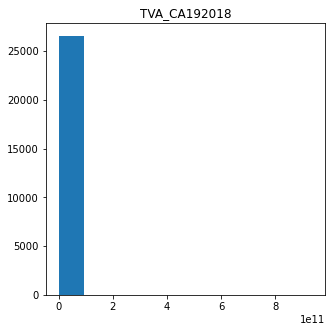

******************************************************************************************************************************************************


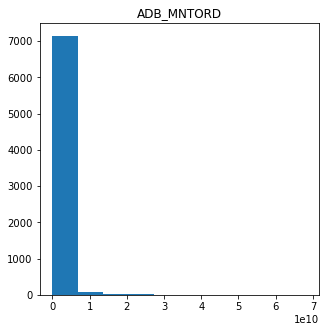

******************************************************************************************************************************************************


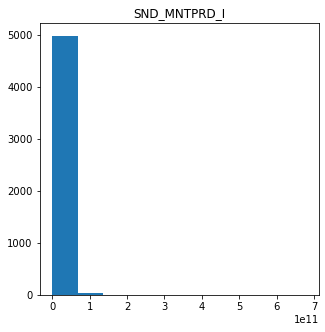

******************************************************************************************************************************************************


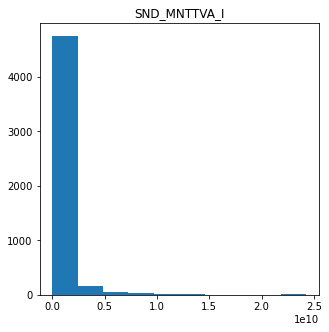

******************************************************************************************************************************************************


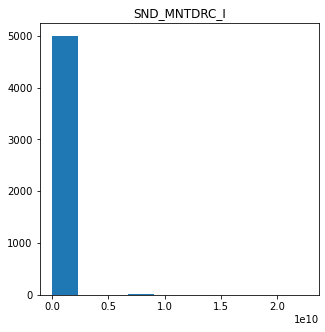

******************************************************************************************************************************************************


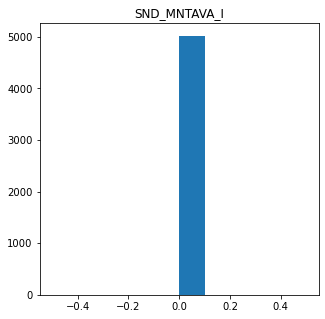

******************************************************************************************************************************************************


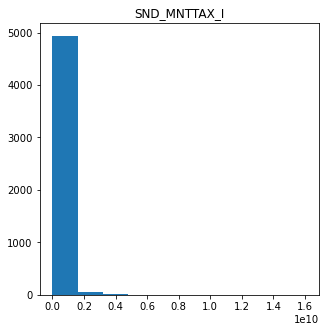

******************************************************************************************************************************************************


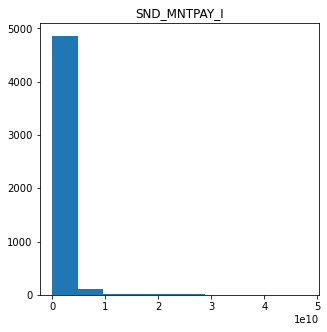

******************************************************************************************************************************************************


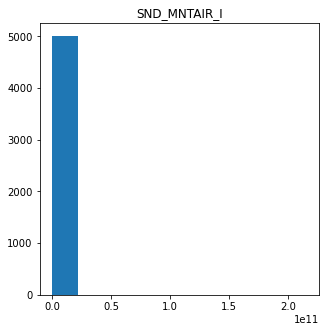

******************************************************************************************************************************************************


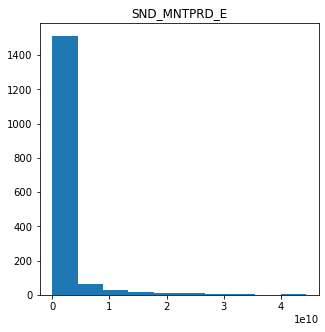

******************************************************************************************************************************************************


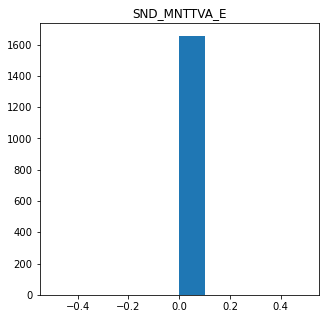

******************************************************************************************************************************************************


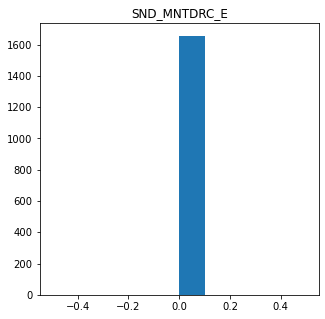

******************************************************************************************************************************************************


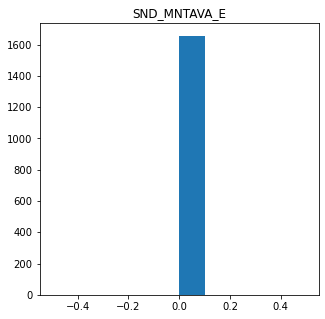

******************************************************************************************************************************************************


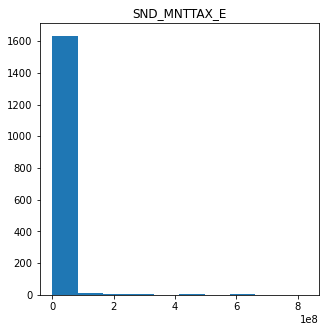

******************************************************************************************************************************************************


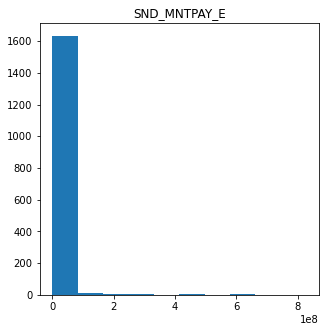

******************************************************************************************************************************************************


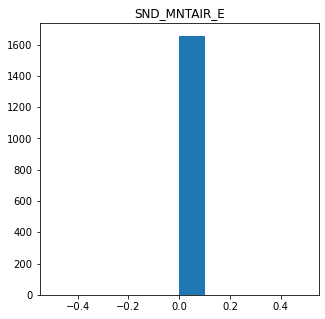

******************************************************************************************************************************************************


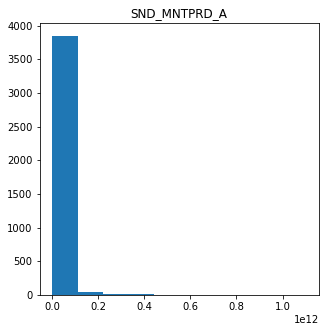

******************************************************************************************************************************************************


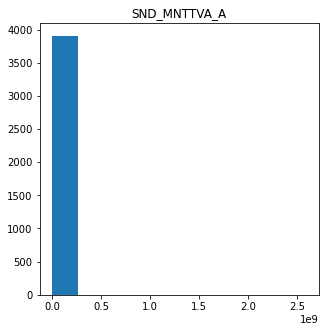

******************************************************************************************************************************************************


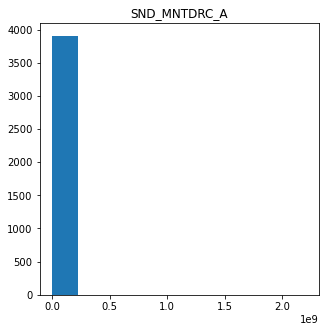

******************************************************************************************************************************************************


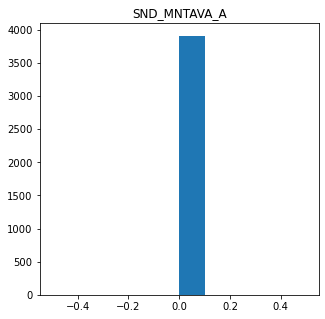

******************************************************************************************************************************************************


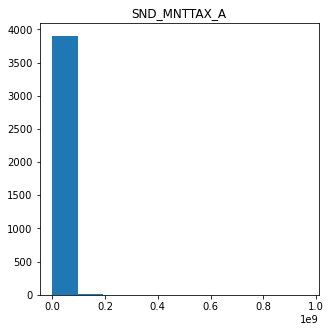

******************************************************************************************************************************************************


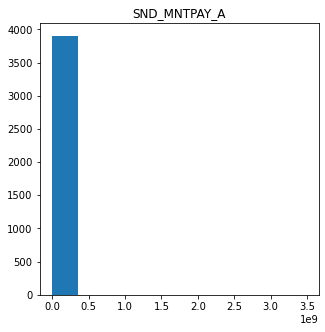

******************************************************************************************************************************************************


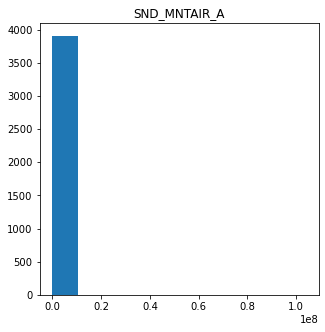

******************************************************************************************************************************************************


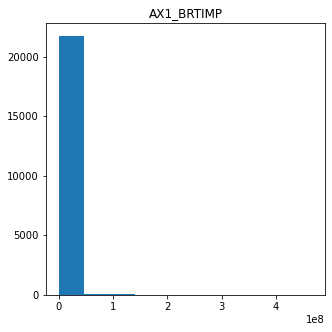

******************************************************************************************************************************************************


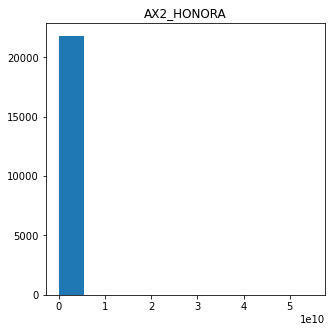

******************************************************************************************************************************************************


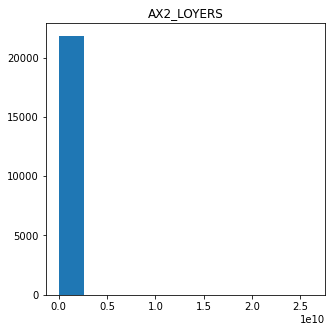

******************************************************************************************************************************************************


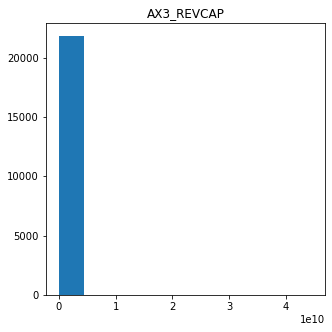

******************************************************************************************************************************************************


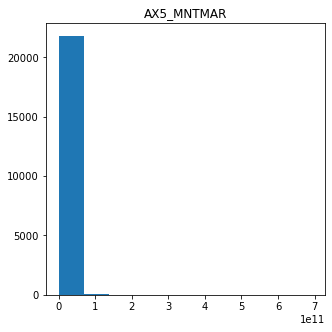

******************************************************************************************************************************************************


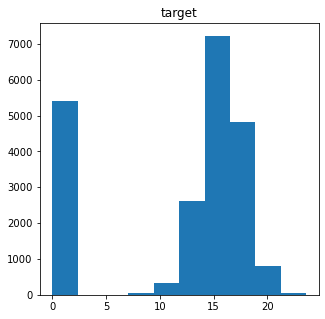

******************************************************************************************************************************************************


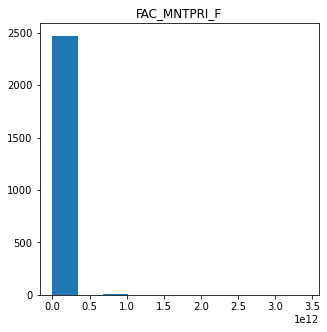

******************************************************************************************************************************************************


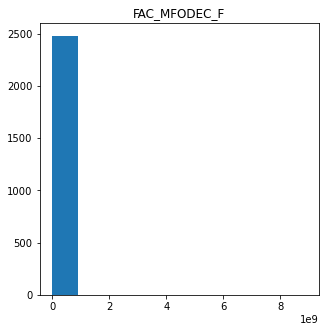

******************************************************************************************************************************************************


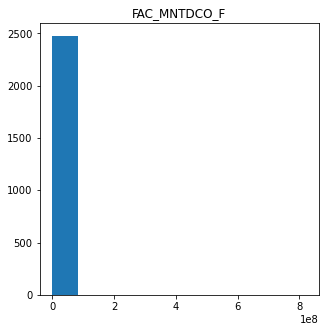

******************************************************************************************************************************************************


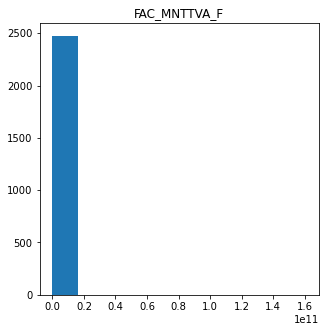

******************************************************************************************************************************************************


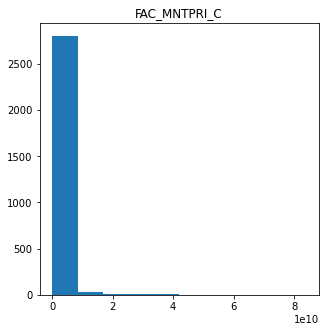

******************************************************************************************************************************************************


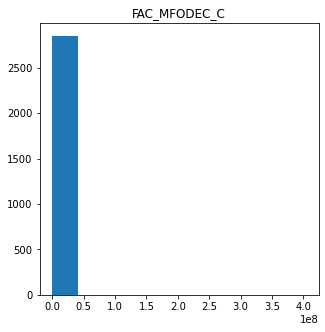

******************************************************************************************************************************************************


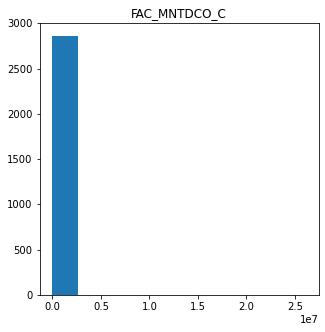

******************************************************************************************************************************************************


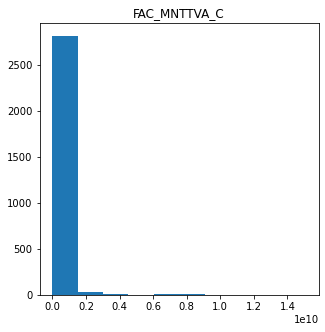

******************************************************************************************************************************************************


In [12]:
# The distribution of variables
for column in continuous_col:
  plt.figure(figsize = (5,5))
  plt.hist(data[column])
  plt.title(column)
  #plt.ylim((1,5))
  plt.show()
  print( '***' * 50)

In [13]:
# All the values in some variables are only zeros. 
col_only_zeros = []
for column in continuous_col:
  if data[column].max() == 0 and data[column].min() == 0:
    col_only_zeros.append(column)

print(len(col_only_zeros))
print(col_only_zeros)

11
['TVA_CAF125', 'TVA_CHAF36', 'TVA_MTORDTAX', 'TVA_MTDJRTAX', 'TVA_MTRESTAX', 'SND_MNTAVA_I', 'SND_MNTTVA_E', 'SND_MNTDRC_E', 'SND_MNTAVA_E', 'SND_MNTAIR_E', 'SND_MNTAVA_A']


### Understanding the object data type

In [14]:
print(cat_col)

['CTR_CATEGO_X', 'id']


We will drop the id column. 
the 'CTR_CATEGO_X' variable will be converted into dummies

## Redundant Variables


In [15]:
redundant_col = int_col_drop + col_only_zeros + ['id']
print(len(redundant_col),redundant_col)

19 ['BCT_CODBUR', 'CTR_MATFIS', 'FJU_CODFJU', 'CTR_CESSAT', 'ACT_CODACT', 'EXE_EXERCI', 'RES_ANNIMP', 'TVA_CAF125', 'TVA_CHAF36', 'TVA_MTORDTAX', 'TVA_MTDJRTAX', 'TVA_MTRESTAX', 'SND_MNTAVA_I', 'SND_MNTTVA_E', 'SND_MNTDRC_E', 'SND_MNTAVA_E', 'SND_MNTAIR_E', 'SND_MNTAVA_A', 'id']


## Handing missing values

In [16]:
# Function to handle missing values
def missing_values(data, threshold = 70.0):
    drop_columns = []
    keep_columns = []
    columns = data.columns 
    for column in columns:
        missing_val_percent = (100 * data[column].isna().sum() / len(data))
        if missing_val_percent >= threshold:
            drop_columns.append(column)
        else:
            keep_columns.append(column)
    return (drop_columns, keep_columns)

In [17]:
# Columns to drop and those to keep due to missing values
drop_columns , keep_columns = missing_values(data)

print('Number of columns with more than 70% missing values:', len(drop_columns))
print('Number of columns to keep:', len(keep_columns))

Number of columns with more than 70% missing values: 30
Number of columns to keep: 91


There are 30 columns with more than 70% missing values. We will drop all those columns.

In [18]:
# Columns to keep 
data[keep_columns].head()

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,TVA_CA132018,TVA_CA192018,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR,RES_ANNIMP,target,id
0,44,6210,C,99,0,3707,4,2,2,2,...,0.0,0.0,0.0,2950000.0,0.0,0.0,602769328.0,2014,16.639203,train_id17437
1,401,14383,M,22,0,6105,4,2,2,2,...,0.0,0.0,0.0,203353885.0,0.0,0.0,14785200.0,2013,17.827703,train_id5086
2,243,11555,M,23,0,5751,4,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,10792800.0,2013,15.473503,train_id1443
3,72,6175,C,99,0,4402,4,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,0.000000,train_id15469
4,42,1417,M,23,0,6302,4,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,14.286244,train_id14368


In [21]:
# Combine all the columns we are going to drop
for column in drop_columns:
  if column not in redundant_col:
    redundant_col.append(column)
print(' Total number of redundant columns:', len(redundant_col))

 Total number of redundant columns: 43


In [22]:
# Drop redundant columns
data2 = data.drop(redundant_col, axis = 1)
print(data2.shape)
data2.head()

(28812, 78)


,CTR_CATEGO_X,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,CTR_OBLDCO,CTR_OBLTVA,CTR_OFODEC,CTR_OFODEP,...,TVA_MTDJRTVA,TVA_CA072018,TVA_CA132018,TVA_CA192018,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR,target
0,C,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2950000.0,0.0,0.0,602769328.0,16.639203
1,M,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,203353885.0,0.0,0.0,14785200.0,17.827703
2,M,4,2,2,2,2,1,2,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10792800.0,15.473503
3,C,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,M,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.286244


Now we only have 78 features!

## Handling Categorical Variables

There is one categorical feature i.e. CTR_CATEGO_X

In [23]:
data2.CTR_CATEGO_X.unique()

array(['C', 'M', 'P', 'N'], dtype=object)

In [24]:
# Convert the Categorical columns to dummies
data2 = pd.get_dummies(.drop(redundant_var, axis = 1))

SyntaxError: invalid syntax (Temp/ipykernel_8248/1304355388.py, line 2)

In [25]:
data_raw.head()

NameError: name 'data_raw' is not defined

In [26]:
print (data2.columns)

Index(['CTR_CATEGO_X', 'CTR_OBLDIR', 'CTR_OBLACP', 'CTR_OBLRES', 'CTR_OBLFOP',
       'CTR_OBLTFP', 'CTR_OBLDCO', 'CTR_OBLTVA', 'CTR_OFODEC', 'CTR_OFODEP',
       'CTR_OFODET', 'CTR_OBLAUT', 'CTR_OBLASS', 'CTR_ODTIMB', 'CTR_OBLTCL',
       'CTR_OBLTHO', 'CTR_OBLDLI', 'CTR_OBLTVI', 'CTR_RATISS', 'TVA_CHAFF6',
       'TVA_CHAFF7', 'TVA_CHAF10', 'TVA_CHAF12', 'TVA_CHAF15', 'TVA_CHAF18',
       'TVA_CHAF22', 'TVA_CHAF29', 'TVA_TOTDUE', 'TVA_MOIDEB', 'TVA_CRDINI',
       'TVA_BASIMB', 'TVA_DEDIMB', 'TVA_BASEQL', 'TVA_DEDEQL', 'TVA_BASEQI',
       'TVA_DEDEQI', 'TVA_BASAUL', 'TVA_DEDAUL', 'TVA_BASAUI', 'TVA_DEDAUI',
       'TVA_BASRSM', 'TVA_DEDRSM', 'TVA_RSNRES', 'TVA_TRSPOR', 'TVA_DEDREG',
       'TVA_RESTIT', 'TVA_MNTPAY', 'TVA_MOIFIN', 'TVA_CRDFIN', 'TVA_ACHSUS',
       'TVA_ACHEXO', 'TVA_ACHNDD', 'TVA_CAFEXP', 'TVA_CAFSUS', 'TVA_CAFEXO',
       'TVA_AACHAB', 'TVA_CRDBLQ', 'TVA_CRDRES', 'TVA_CRDRMP', 'TVA_CRDREP',
       'TVA_CRDRMC', 'TVA_MACHN', 'TVA_MCESQ', 'TVA_MTVLSM', 'TVA_TXVLSM',

In [27]:
data2.tail()

,CTR_CATEGO_X,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,CTR_OBLDCO,CTR_OBLTVA,CTR_OFODEC,CTR_OFODEP,...,TVA_MTDJRTVA,TVA_CA072018,TVA_CA132018,TVA_CA192018,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR,target
28807,P,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,11081824.0,0.0,0.0,0.0,NaN
28808,M,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
28809,M,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,437736724.0,NaN
28810,M,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264422595.0,NaN
28811,M,4,2,2,2,2,1,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,169528840.0,0.0,86024248.0,NaN


In [28]:
# Drop columns
drop = ['target', 'CTR_CATEGO_X_N']
data3 = data2.drop(drop, axis =1)
print(data3.shape)
data3.head()

KeyError: "['CTR_CATEGO_X_N'] not found in axis"

## Handling Outliers

We want to use the Median Interquartile range method to detect outliers

In [29]:
def columns_with_outliers(data, threshold = 1.5):
  columns = data.columns
  outlier_columns = []
  no_outliers_col = []
  for column in columns:
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    for i in range(len(data[column])):
      if (data[column][i] < lower_bound) or (data[column][i] > lower_bound):
        if column not in outlier_columns:
          outlier_columns.append(column)
      else:
        no_outliers_col.append(column)
  return outlier_columns, no_outliers_col

In [30]:
outlier_columns, no_outliers_col = columns_with_outliers(data2)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
print(len(outlier_columns))
print(outlier_columns)

13
['CTR_OBLDIR', 'CTR_OBLACP', 'CTR_OBLRES', 'CTR_OBLFOP', 'CTR_OBLTFP', 'CTR_OBLDCO', 'CTR_OBLTVA', 'CTR_OBLTCL', 'CTR_RATISS', 'CTR_CATEGO_X_C', 'CTR_CATEGO_X_M', 'CTR_CATEGO_X_N', 'CTR_CATEGO_X_P']


In [ ]:
for column in outlier_columns:
  plt.figure(figsize = (5,5))
  plt.hist(data2[column])
  plt.title(column)
  #plt.ylim((1,5))
  plt.show()
  print( '***' * 50)

## Impute Missing Values

In [ ]:
from sklearn.impute import SimpleImputer

impute = SimpleImputer(strategy= 'median')
data4 = impute.fit_transform(data3)
data4 = pd.DataFrame(data3, columns = data3.columns)
print('Imputing missing values with median...Done')

Imputing missing values with mean...Done


In [ ]:
train_imp.head()

,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,CTR_OBLDCO,CTR_OBLTVA,CTR_OFODEC,CTR_OFODEP,CTR_OFODET,CTR_OBLAUT,CTR_OBLASS,CTR_ODTIMB,CTR_OBLTCL,CTR_OBLTHO,CTR_OBLDLI,CTR_OBLTVI,CTR_RATISS,TVA_CHAFF6,TVA_CHAFF7,TVA_CHAF10,TVA_CHAF12,TVA_CHAF15,TVA_CHAF18,TVA_CHAF22,TVA_CHAF29,TVA_TOTDUE,TVA_MOIDEB,TVA_CRDINI,TVA_BASIMB,TVA_DEDIMB,TVA_BASEQL,TVA_DEDEQL,TVA_BASEQI,TVA_DEDEQI,TVA_BASAUL,TVA_DEDAUL,TVA_BASAUI,TVA_DEDAUI,TVA_BASRSM,...,TVA_TXVLSM,TVA_MTALSM,TVA_TXALSM,TVA_MTORDTVA,TVA_MTDJRTVA,TVA_CA072018,TVA_CA132018,TVA_CA192018,ADB_MNTORD,SND_MNTPRD_I,SND_MNTTVA_I,SND_MNTDRC_I,SND_MNTTAX_I,SND_MNTPAY_I,SND_MNTAIR_I,SND_MNTPRD_E,SND_MNTTAX_E,SND_MNTPAY_E,SND_MNTPRD_A,SND_MNTTVA_A,SND_MNTDRC_A,SND_MNTTAX_A,SND_MNTPAY_A,SND_MNTAIR_A,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,CTR_CATEGO_X_C,CTR_CATEGO_X_M,CTR_CATEGO_X_P
0,4.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,126423147.0,0.0,755492735.0,0.0,0.0,151159466.0,1.0,0.0,0.0,0.0,203502320.0,40671108.0,168448614.0,23214917.0,237652610.0,39987369.0,52750313.0,7884392.0,7969950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.319000e+05,1.927178e+08,2.437462e+07,0.000000e+00,3.947479e+06,2.832210e+07,7.401960e+05,3.007700e+07,0.000000e+00,0.000000e+00,8.520463e+09,1.874537e+06,1.682826e+06,1.653357e+06,5.210720e+06,64352.858227,0.0,2950000.0,0.0,0.0,602769328.0,9.471275e+09,6.632605e+06,93068.732967,4.903870e+08,8.420356e+08,1.489097e+06,31918.204449,1.386915e+08,1.0,0.0,0.0
1,4.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,21916400.0,0.0,0.0,0.0,0.0,2629968.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2772366.0,499026.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.418124e+08,3.585463e+09,5.136035e+08,4.587685e+07,1.410969e+08,6.974169e+08,3.941514e+08,1.641282e+09,5.109028e+06,5.109028e+06,8.520463e+09,1.874537e+06,1.682826e+06,1.653357e+06,5.210720e+06,64352.858227,0.0,203353885.0,0.0,0.0,14785200.0,9.471275e+09,6.632605e+06,93068.732967,4.903870e+08,8.420356e+08,1.489097e+06,31918.204449,1.386915e+08,0.0,1.0,0.0
2,4.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20373500.0,0.0,0.0,3667230.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19552556.0,3411102.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.418124e+08,3.585463e+09,5.136035e+08,4.587685e+07,1.410969e+08,6.974169e+08,3.941514e+08,1.641282e+09,5.109028e+06,5.109028e+06,8.520463e+09,1.874537e+06,1.682826e+06,1.653357e+06,5.210720e+06,64352.858227,0.0,0.0,0.0,0.0,10792800.0,2.538700e+07,0.000000e+00,0.000000,4.571280e+06,8.420356e+08,1.489097e+06,31918.204449,1.386915e+08,0.0,1.0,0.0
3,4.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,0.0,61381586.0,0.0,0.0,0.0,0.0,338481203.0,0.0,0.0,64609507.0,1.0,26974794.0,0.0,0.0,0.0,0.0,0.0,0.0,306229381.0,55121289.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.418124e+08,3.585463e+09,5.136035e+08,4.587685e+07,1.410969e+08,6.974169e+08,3.941514e+08,1.641282e+09,5.109028e+06,5.109028e+06,8.520463e+09,1.874537e+06,1.682826e+06,1.653357e+06,5.210720e+06,64352.858227,0.0,0.0,0.0,0.0,0.0,9.471275e+09,6.632605e+06,93068.732967,4.903870e+08,8.420356e+08,1.489097e+06,31918.204449,1.386915e+08,1.0,0.0,0.0
4,4.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.418124e+08,3.585463e+09,5.136035e+08,4.587685e+07,1.410969e+08,6.974169e+08,3.941514e+08,1.641282e+09,5.109028e+06,5.109028e+06,8.520463e+09,1.874537e+06,1.682826e+06,1.653357e+06,5.210720e+06,64352.858227,0.0,0.0,0.0,0.0,0.0,9.471275e+09,6.632605e+06,93068.732967,4.903870e+08,8.420356e+08,1.489097e+06,31918.204449,1.386915e+08,0.0,1.0,0.0


## Scaling 

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
data_sc_raw = scaler.fit_transform(data_raw)
data_sc_raw = pd.DataFrame(data_sc_raw, columns = data_raw.columns)

## Ready Data for Modeling 

In [ ]:

#Train and test datasets
train = data_sc_raw[:ntrain].copy()
test = data_sc_raw[ntrain:].copy()
test = test.reset_index(drop=True)

In [ ]:
print('train:',train.shape)
print('test:', test.shape)

train: (21295, 122)
test: (7517, 122)


In [ ]:
target.shape

(21295,)

In [ ]:
# xgboost for regression
from numpy import mean
from numpy import std
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate the model
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, train, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('XGBM MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_xg = XGBRegressor(objective='reg:squarederror')
model_xg.fit(train, target)

XGBM MSE: -37.072 (0.569)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# lightgbm for regression
from numpy import mean
from numpy import std
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate the model
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, train, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('LGBM MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_lg = LGBMRegressor()
model_lg.fit(train, target)

LGBM MSE: -35.068 (0.616)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
LGBM MSE: -37.315 (0.719)

In [ ]:
# catboost for regression
from numpy import mean
from numpy import std
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
# evaluate the model
model = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, train, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('CAT MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_cat = CatBoostRegressor(verbose=0, n_estimators=100)
model_cat.fit(train, target)

CAT MSE: -36.091 (0.685)


## Stacking 

In [ ]:
# make a prediction with a stacking ensemble
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# define the base models
level0 = list()
level0.append(('lgbm', model_lg))
level0.append(('cat', model_cat))
level0.append(('xgbm', model_xg))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(train, target)
stack_result = model.predict(test)

In [ ]:
stack_result[:10]

array([16.11441921, 15.10360436, 13.95472715, 15.0673951 , 13.9914744 ,
        9.68052537, 14.95604822, 11.67283406, 13.5222814 , 14.18268654])

## Submission file 

In [ ]:
Submission['target'] = stack_result #model_lg.predict(test) 
file_name = 'submission12-stack3-raw.csv'
Submission.to_csv('Tunisian_Fraud_Detection/Submissions/' + file_name ,index=False)

In [ ]:
Submission.head()

,id,target
0,test_id1120,15.833178
1,test_id1680,14.761067
2,test_id1063,13.386049
3,test_id3731,15.366750
4,test_id9766,14.362651
